In [1]:
# custom imports
import utils
from zombihop import *

# standard imports
import pandas as pd
import numpy as np
import joblib
import random
import os

# ZoMBI-Hop: 
## Working Example for Running Virtual Optimization

### Load Example Dataset

<div>
<img src="./data/needle_manifold_R1.png" align = "center" width="500" />
</div>

#### Dataset: Negative Poisson's Ratio Materials Discovery (see [https://www.nature.com/articles/s41524-023-01048-x](https://www.nature.com/articles/s41524-023-01048-x))

The virtual optimization mode uses a Random Forest Regression over a dataset of 146,000 materials from the Materials Project in place of real experimental measurements. This RF is withheld from the optimizer and is only used to draw experiments.


In [ ]:
# Load Negative Poisson's Ratio data set for virtual optimization

# === USER PARAMETERS ===#
n_init = 20 # number of initial data points sampled to construct initialization set
seed = 1 # random seed for model reproducibility, IMPORTANT: *change every time a new independent trial is run*
# =======================#

# Load full dataset to draw random initialization set
chem_props = pd.read_pickle(os.getcwd()+'\\data\\Material_Properties_Negative_Poisson').reset_index(drop=True)
X = chem_props.loc[:,['density','energy_per_atom','efermi','energy_above_hull','band_gap']]
Y = chem_props[['homogeneous_poisson']]
X_norm = utils.m_norm(X) # normalize X-coordinates

# Load pseudo-experimental data: random forest regression of dataset
poisson_model = joblib.load(os.getcwd()+'\\data\\poisson_RF_trained.pkl') # load the trained model
poisson_model = poisson_model.predict # call the prediction function

# Draw random initialization set of n_init points
random.seed(seed) # initialize a random seed
rand_init = random.sample(range(X_norm.index.values.min(), X_norm.index.values.max()), n_init)
X_init = X_norm.iloc[rand_init,:]
Y_init = pd.DataFrame(poisson_model(np.array(X_init)), columns = Y.columns.values) # grab init data from "experimental" RF

### Run the ZoMBI-Hop Optimizer

In [2]:
optimizer = ZombiHop(
                    seed = seed,                         # A random seed for model reproducibility, IMPORTANT: *change every time a new independent trial is run*
                    X_init = X_init,                     # An (n, d) array of normalized [0,1] initialization coordinates, where n is the number of initial points and d is the number of dimensions
                    Y_init = Y_init,                     # An (n, 1) array of values, corresponding to the X_init coordinates, where n is the number of initial points
                    Y_experimental = poisson_model,      # A model of the form Y_experimental() that can take an (n, d) dimensional array of coordinates (X) to predict an output (Y) => supplements for experimental data
                    Gammas = 10,                         # Number of hops to other needles
                    alphas = 4,                          # Number of ZoMBI zoom-ins for each hop
                    n_draws_per_activation = 10,         # Number of samples drawn for each zoom-in
                    acquisition_type = LCB_ada,          # Acquisition function model to conduct sampling of new points
                    tolerance = 0.03,                    # Error tolerance of GP prediction, used to end a ZoMBI zoom-in and move to the next needle
                    penalty_width = 0.2,                 # Width of penalty region about needle => inhibits BO searching from areas surrounding previously found needles
                    m = 5,                               # Top m-number of data points used to zoom in bounds
                    k = 5,                               # Top k-number of data points to keep
                    lower_bound = np.zeros(X.shape[1]),  # An (d,) array of lower bound coordinates for each dimension (d) to begin the search
                    upper_bound = np.ones(X.shape[1]),   # An (d,) array of upper bound coordinates for each dimension (d) to begin the search
                    resolution = 10,                     # Number for the resolution of the mesh search space, e.g., resolution=10
                    sampler = None                       # Either None or a sampler that takes in X_ask (1,d), dimension_meshes (n,d), acquisitions (n,), and Y_experimental (model) 
                                                         # to generate X_tell (n,d) and Y_tell (n,)
                    )

X_all, Y_all, needle_locs, needles = optimizer.run_virtual(verbose = False, plot = True) # Run virtual optimization

NameError: name 'seed' is not defined

### Plot Optimizer Results

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for n in range(needles.shape[0]):
    plt.axhline(needles.iloc[n,0], c='r', ls='-', lw=0.5, alpha=1, label='Discovered Needles')
plt.scatter(Y_all.index, Y_all, c='k')
plt.ylabel('Poission\'s Ratio')
plt.xlabel('Number of Experiments')
plt.grid()
plt.legend(['Discovered Needles'])
plt.show()

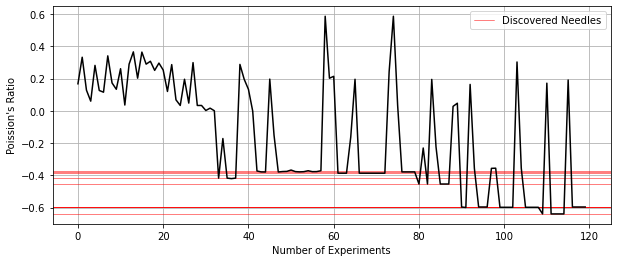

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for n in range(needles.shape[0]):
    plt.axhline(needles.iloc[n,0], c='r', ls='-', lw=0.5, alpha=1, label='Discovered Needles')
plt.plot(Y_all, c='k')
plt.ylabel('Poission\'s Ratio')
plt.xlabel('Number of Experiments')
plt.grid()
plt.legend(['Discovered Needles'])
plt.show()